In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point
from pyproj import Proj, Transformer

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Subway-single network 

## Generate Baseline network

In [4]:
# Obtain sub-stations in the city
city_sub_stations = sub_stations(osm_path)

In [5]:
# Obtain subway network data
city_sub_network = subway_network(osm_path)

# Prepare the network edges and nodes based on sub-stations and subway network
edges, nodes = prepare_network(city_sub_network, city_sub_stations)

# Expand the edges if required
edges = expand_edges(edges)

# Obtain sub-routes in the city
city_sub_routes = sub_routes(osm_path)

# Sort the sub-routes
city_sub_routes = sorted_routes(city_sub_routes)

# Check the name and assign a column
check_name = check_to_column(city_sub_routes, city_sub_stations)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 8886.88it/s]


In [6]:
# delete 3 pairs useless and wrong edges 
edges.drop(edges[(edges['from_id'] == 771) & (edges['to_id'] == 761)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 771) & (edges['to_id'] == 766)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 762) & (edges['to_id'] == 771)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 767) & (edges['to_id'] == 771)].index, inplace=True)

edges.drop(edges[(edges['from_id'] == 780) & (edges['to_id'] == 773)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 780) & (edges['to_id'] == 772)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 774) & (edges['to_id'] == 780)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 775) & (edges['to_id'] == 780)].index, inplace=True)

edges.drop(edges[(edges['from_id'] == 180) & (edges['to_id'] == 345)].index, inplace=True)

In [7]:
# revise Zuid metro stations' coordinates, replace 712 with 180 and 345 nodes to avoid wrong shortest-path edges
geometry_value1 = nodes.loc[nodes['id'] == 180, 'geometry'].values[0]
geometry_value2 = nodes.loc[nodes['id'] == 345, 'geometry'].values[0]

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geometry'] = geometry_value1
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_x'] = geometry_value1.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_y'] = geometry_value1.y

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geometry'] = geometry_value2
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_x'] = geometry_value2.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_y'] = geometry_value2.y

In [8]:
# gpd.GeoDataFrame(edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('sub_edges_0304.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_sub_stations[['osm_id', 'geometry','name']]).to_file('city_sub_stations_0304.GPKG',driver='GPKG')

In [9]:
replacement_dict = {
     'Amsterdam Centraal': 'Centraal Station',
}

In [10]:
# Replace values in the 'to' column of the metro routes using the replacement dictionary
city_sub_routes['to'] = city_sub_routes['to'].replace(replacement_dict, regex=True).str.strip()

# Reset the index of the metro routes
city_sub_routes = city_sub_routes.reset_index(drop=True)

# Check if the values in the 'to' column of the metro routes match the station names
check_name = check_to_column(city_sub_routes, city_sub_stations)

In [11]:
# Create a dictionary mapping start stations to their corresponding routes
city_sub_start_station_name_dict = start_station_dict(city_sub_routes)

# Create a dictionary mapping subway lines to their corresponding routes
city_sub_line_dict = line_dict(city_sub_routes)

# Create a list of all station names in the city's subway network
city_all_sub_stations_name = all_station_list(city_sub_stations)

# Create a dictionary mapping subway lines to the ordered list of stations on each line
city_sub_order_route_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, city_sub_routes, city_sub_start_station_name_dict)

In [12]:
# revise station sequence of 51_1 route
df51_1 = pd.read_excel('C:\\projects\\UTNCE\\data\\Metro 51 Centraal Station = Isolatorweg.xlsx',header=None)
df51_1 = df51_1[0::4].reset_index(drop=True)
df51_1.columns = ['name']
df51_1.name[9] = 'Zuid' 
df51_1.name[13] = 'Lelylaan' 
df51_1.name[16] = 'De Vlugtlaan' 

df = city_sub_order_route_dict['Metro 51: Centraal Station => Isolatorweg']
df_reordered = pd.merge(df51_1,df,on='name')

desired_order = ['id', 'name', 'geometry', 'geo_x', 'geo_y']
df_reordered = df_reordered[desired_order]

key_to_replace = 'Metro 51: Centraal Station => Isolatorweg'
city_sub_order_route_dict[key_to_replace] = df_reordered

# city_sub_order_route_dict

In [13]:
# Create a dictionary mapping subway lines to the pairs of station IDs on each line
city_sub_order_id_pairs = id_pairs_inline(city_sub_line_dict, city_sub_order_route_dict, nodes)

In [14]:
# revise order_id_pairs of 52 routes--De pijp station where two nodes are too close
df_order_id_52_1 = city_sub_order_id_pairs['Metro 52: Noord => Zuid']
df_order_id_52_1
df_order_id_52_1.e_id[4] = 863
df_order_id_52_1.s_id[5] = 863

df_order_id_52_2 = city_sub_order_id_pairs['Metro 52: Zuid => Noord']
df_order_id_52_2
df_order_id_52_2.s_id[2] = 864
df_order_id_52_2.e_id[1] = 864

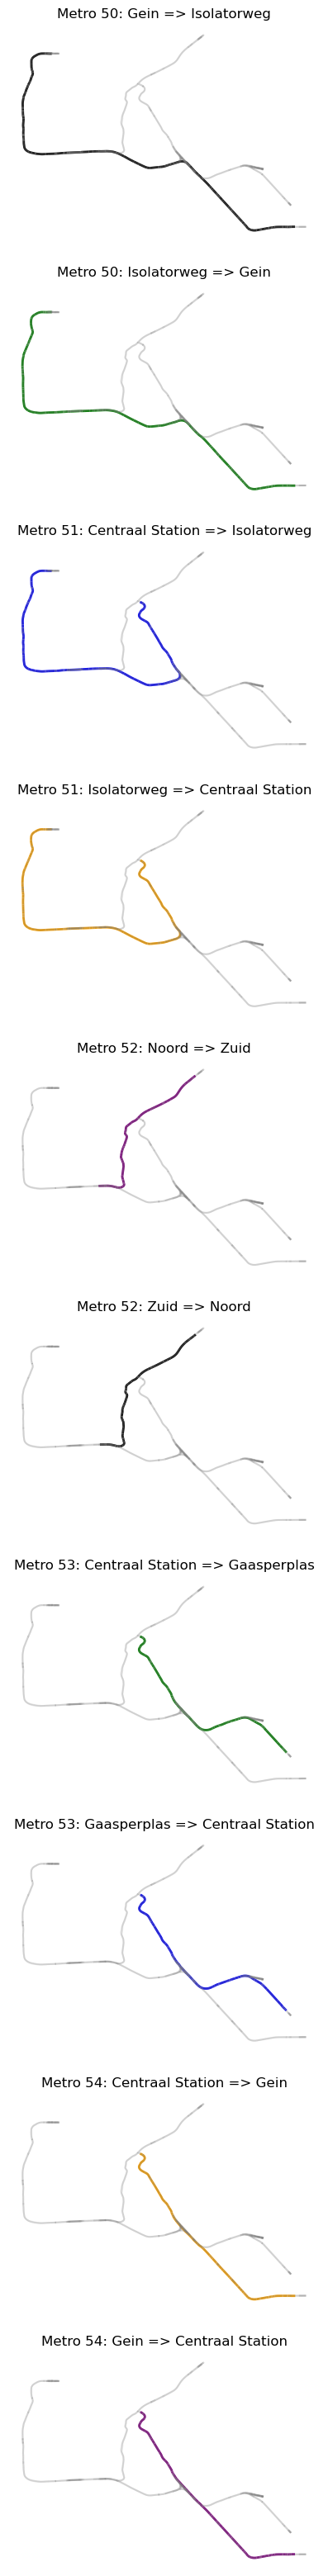

In [15]:
# Create a graph representing the subway network using the extracted edges and nodes
G = create_ground_graph(edges, nodes)

# Calculate the shortest path pairs for each subway line
city_sub_shortest_path_pairs = city_sub_order_id_pairs.copy()
duplicate_row_count = city_sub_order_id_pairs.copy()
city_sub_shortest_path_edges = city_sub_order_id_pairs.copy()
city_sub_edges = city_sub_order_id_pairs.copy()

for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the subway network edges
    city_sub_shortest_path_pairs[line] = all_shortest_paths(G, city_sub_order_id_pairs[line], edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the subway network edges for the current line
    duplicate_row_count[line], city_sub_shortest_path_edges[line], city_sub_edges[line] = edges_with_count_weight(city_sub_shortest_path_pairs[line], edges)
    sub_edges = city_sub_edges[line]

# # Plot the subway routes with even indices
# plot_routes_even(city_sub_routes, edges, city_sub_shortest_path_edges)

# # Plot the subway routes with odd indices
# plot_routes_odd(city_sub_routes, edges, city_sub_shortest_path_edges)
    
# Plot all subway routes
plot_routes(city_sub_routes, edges, city_sub_shortest_path_edges)

In [16]:
# df51_1 = city_sub_shortest_path_edges['Metro 50: Gein => Isolatorweg']
# df51_2 = city_sub_shortest_path_edges['Metro 50: Isolatorweg => Gein']

# df52_1 = city_sub_shortest_path_edges['Metro 52: Noord => Zuid'] 
# df52_2 = city_sub_shortest_path_edges['Metro 52: Zuid => Noord']

# df53_1 = city_sub_shortest_path_edges['Metro 53: Centraal Station => Gaasperplas']
# df53_2 = city_sub_shortest_path_edges['Metro 53: Gaasperplas => Centraal Station']

# df54_1 = city_sub_shortest_path_edges['Metro 54: Centraal Station => Gein']
# df54_2 = city_sub_shortest_path_edges['Metro 54: Gein => Centraal Station']

In [17]:
# gpd.GeoDataFrame(df51_1[['osm_id', 'geometry','id']]).to_file('df51_1_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df51_2[['osm_id', 'geometry','id']]).to_file('df51_2_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df52_1[['osm_id', 'geometry','id']]).to_file('df52_1_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df52_2[['osm_id', 'geometry','id']]).to_file('df52_2_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df53_1[['osm_id', 'geometry','id']]).to_file('df53_1_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df53_2[['osm_id', 'geometry','id']]).to_file('df53_2_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df54_1[['osm_id', 'geometry','id']]).to_file('df54_1_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df54_2[['osm_id', 'geometry','id']]).to_file('df54_2_0314.GPKG',driver='GPKG')

## Add columns to stations

In [18]:
city_sub_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_order_route_dict, city_sub_routes)

In [19]:
city_sub_new_nodes = add_columns_to_nodes(city_sub_order_route_dict, nodes)

In [20]:
city_sub_new_nodes

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (4.98916 52.29641),2,328,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
1,POINT (4.97400 52.29564),2,855,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
2,POINT (4.96013 52.29813),2,854,Holendrecht,4.960126,52.298132,"(4.9601264, 52.2981319)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
3,POINT (4.95213 52.30687),2,810,Bullewijk,4.952129,52.306869,"(4.9521292, 52.306869)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
4,POINT (4.94762 52.31181),2,809,Bijlmer ArenA,4.947618,52.311806,"(4.9476178, 52.311806)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
...,...,...,...,...,...,...,...,...,...,...,...
82,POINT (4.96734 52.32837),2,824,Verrijn Stuartweg,4.967335,52.328367,"(4.9673352, 52.3283668)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
83,POINT (4.95669 52.33041),2,823,Station Diemen Zuid,4.956688,52.330406,"(4.9566878, 52.3304057)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
84,POINT (4.94628 52.32683),2,829,Venserpolder,4.946277,52.326833,"(4.9462773, 52.3268326)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
85,POINT (4.93028 52.32974),2,827,Van der Madeweg,4.930285,52.329735,"(4.9302846, 52.3297352)",Metro 53: Gaasperplas => Centraal Station,subway,"50, 53, 54","50, 53, 54"


In [21]:
city_sub_new_nodes[city_sub_new_nodes.name == 'Reigersbos']

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
1,POINT (4.97400 52.29564),2,855,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
38,POINT (4.97438 52.29560),2,144,Reigersbos,4.974377,52.295596,"(4.9743774, 52.2955964)",Metro 50: Isolatorweg => Gein,subway,"50, 54","50, 54"


## Add columns to edges

In [22]:
city_sub_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_shortest_path_edges, city_sub_routes)

In [23]:
city_sub_new_edges = add_columns_to_edges(city_sub_shortest_path_edges,edges)

In [24]:
column_to_drop = 'count_weight'
city_sub_new_edges = city_sub_new_edges.drop(columns=column_to_drop)

In [25]:
city_sub_new_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,0,1,258.660599,0.010346,258,"(0, 1)","(1, 0)",Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(2, 3)","(3, 2)",Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(4, 5)","(5, 4)",Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,6,7,28.046592,0.001122,28,"(6, 7)","(7, 6)",NaN,NaN,NaN
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,8,492,382.935219,0.015317,382,"(8, 492)","(492, 8)",Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,1131538381,"LINESTRING (4.9200955 52.3417374, 4.9200444 52...",subway,None,957,803,463,73.656989,0.002946,73,"(803, 463)","(463, 803)",Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
949,1131538382,"LINESTRING (4.9201445 52.3416568, 4.9200955 52...",subway,None,958,462,803,9.568427,0.000383,9,"(462, 803)","(803, 462)",Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
950,1131538383,"LINESTRING (4.9200365 52.3417239, 4.9200773 52...",subway,None,959,804,246,9.568874,0.000383,9,"(804, 246)","(246, 804)",Metro 51: Isolatorweg => Centraal Station,subway,51
951,1131538384,"LINESTRING (4.9197172 52.3423576, 4.9197589 52...",subway,None,960,463,804,73.789113,0.002952,73,"(463, 804)","(804, 463)",Metro 51: Isolatorweg => Centraal Station,subway,51


# Create original points dataframe and OD pair list

In [26]:
origin_df = pd.DataFrame()
each_o_point = pd.DataFrame()

for route_name, station_df in city_sub_order_route_dict.items():
    each_o_point = station_df.loc[[0]]
    origin_df = pd.concat([origin_df,each_o_point])

origin_df.drop_duplicates(subset='geometry', inplace=True)
selected_columns = ['geometry','geo_x','geo_y','name']

origin_df = origin_df[selected_columns].reset_index(drop=True)

In [27]:
# 将两个方向的同一站都保存成origin station的情况--与目前20240314的test_OD_metro冲突,暂不考虑,先保留在这er
# origin_df = pd.DataFrame()

# for route_name, station_df in city_sub_order_route_dict.items():
#     first_row = station_df.iloc[0]
#     last_row = station_df.iloc[-1]
#     each_o_point = pd.DataFrame([first_row, last_row])
#     origin_df = pd.concat([origin_df,each_o_point])

# origin_df.drop_duplicates(subset='geometry', inplace=True)

# selected_columns = ['geometry','geo_x','geo_y','name']
# origin_df = origin_df[selected_columns].reset_index(drop=True)
# origin_df 

In [28]:
# avoid create OD pairs from the zuid station of 52 to other stations
row_to_drop = origin_df[origin_df.name == 'Zuid'].index
origin_df = origin_df.drop(row_to_drop)

In [29]:
origin_df

,geometry,geo_x,geo_y,name
0,POINT (4.9891612 52.2964067),4.989161,52.296407,Gein
1,POINT (4.8505967 52.3952329),4.850597,52.395233,Isolatorweg
2,POINT (4.9008686 52.3773546),4.900869,52.377355,Centraal Station
3,POINT (4.932402 52.4021571),4.932402,52.402157,Noord
5,POINT (4.9842364 52.3115025),4.984236,52.311503,Gaasperplas


In [30]:
origin_name_df = origin_df[['name']]
destination_df = pd.DataFrame()
each_route_destination_df = pd.DataFrame()

for route_name, station_df in city_sub_order_route_dict.items():
    merged_df = pd.merge(station_df, origin_name_df, on='name', how='left', indicator=True)
    each_route_destination_df = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1).reset_index(drop=True)
    destination_df = pd.concat([destination_df, each_route_destination_df])
    
destination_df.drop_duplicates(subset='geometry', inplace=True)
destination_df = destination_df.reset_index(drop=True)
destination_df

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value
0,18,Reigersbos,POINT (4.9740002 52.2956365),4.974,52.295637,Metro 50: Gein => Isolatorweg,50,subway,"(4.9740002, 52.2956365)"
1,17,Holendrecht,POINT (4.9601264 52.2981319),4.960126,52.298132,Metro 50: Gein => Isolatorweg,50,subway,"(4.9601264, 52.2981319)"
2,6,Bullewijk,POINT (4.9521292 52.306869),4.952129,52.306869,Metro 50: Gein => Isolatorweg,50,subway,"(4.9521292, 52.306869)"
3,4,Bijlmer ArenA,POINT (4.9476178 52.311806),4.947618,52.311806,Metro 50: Gein => Isolatorweg,50,subway,"(4.9476178, 52.311806)"
4,3,Strandvliet,POINT (4.9413977 52.3186119),4.941398,52.318612,Metro 50: Gein => Isolatorweg,50,subway,"(4.9413977, 52.3186119)"
...,...,...,...,...,...,...,...,...,...
70,7,Verrijn Stuartweg,POINT (4.9673352 52.3283668),4.967335,52.328367,Metro 53: Gaasperplas => Centraal Station,53,subway,"(4.9673352, 52.3283668)"
71,6,Station Diemen Zuid,POINT (4.9566878 52.3304057),4.956688,52.330406,Metro 53: Gaasperplas => Centraal Station,53,subway,"(4.9566878, 52.3304057)"
72,9,Venserpolder,POINT (4.9462773 52.3268326),4.946277,52.326833,Metro 53: Gaasperplas => Centraal Station,53,subway,"(4.9462773, 52.3268326)"
73,8,Van der Madeweg,POINT (4.9302846 52.3297352),4.930285,52.329735,Metro 53: Gaasperplas => Centraal Station,53,subway,"(4.9302846, 52.3297352)"


In [31]:
destination_df[destination_df.ref == '52']

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value
49,3,Noorderpark,POINT (4.9181114 52.3886982),4.918111,52.388698,Metro 52: Noord => Zuid,52,subway,"(4.9181114, 52.3886982)"
50,0,Rokin,POINT (4.8925639 52.3705391),4.892564,52.370539,Metro 52: Noord => Zuid,52,subway,"(4.8925639, 52.3705391)"
51,6,Vijzelgracht,POINT (4.8910469 52.3606866),4.891047,52.360687,Metro 52: Noord => Zuid,52,subway,"(4.8910469, 52.3606866)"
52,8,De Pijp,POINT (4.8906487 52.3539577),4.890649,52.353958,Metro 52: Noord => Zuid,52,subway,"(4.8906487, 52.3539577)"
53,5,Europaplein,POINT (4.8915605 52.3411785),4.89156,52.341178,Metro 52: Noord => Zuid,52,subway,"(4.8915605, 52.3411785)"
54,4,Zuid,POINT (4.8772326 52.3393181),4.877233,52.339318,Metro 52: Noord => Zuid,52,subway,"(4.8772326, 52.3393181)"
55,3,Zuid,POINT (4.8780248 52.3393025),4.878025,52.339303,Metro 52: Zuid => Noord,52,subway,"(4.8780248, 52.3393025)"
56,5,Europaplein,POINT (4.8914299 52.3419224),4.89143,52.341922,Metro 52: Zuid => Noord,52,subway,"(4.8914299, 52.3419224)"
57,7,De Pijp,POINT (4.8906476 52.3539585),4.890648,52.353958,Metro 52: Zuid => Noord,52,subway,"(4.8906476, 52.3539585)"
58,6,Vijzelgracht,POINT (4.8912207 52.3606661),4.891221,52.360666,Metro 52: Zuid => Noord,52,subway,"(4.8912207, 52.3606661)"


In [32]:
OD_list = []

for index_origin, row_origin in origin_df.iterrows():
    o_geo_x = row_origin['geo_x']
    o_geo_y = row_origin['geo_y']
       
    for index_destination, row_destination in destination_df.iterrows():
        d_geo_x = row_destination['geo_x']
        d_geo_y = row_destination['geo_y']
        
        # Append a dictionary to the list
        OD_list.append({
            's_coordinates_x': o_geo_x,
            's_coordinates_y': o_geo_y,
            'e_coordinates_x': d_geo_x,
            'e_coordinates_y': d_geo_y
        })

# Create a DataFrame from the list of dictionaries
OD_df = pd.DataFrame(OD_list)  

In [33]:
# delete the OD pairs from central station to other stations of 52 
start_index1 = 199
end_index1 = 210
OD_df = OD_df.drop(range(start_index1, end_index1 + 1))
OD_df = OD_df.reset_index(drop = True)
OD_df

,s_coordinates_x,s_coordinates_y,e_coordinates_x,e_coordinates_y
0,4.989161,52.296407,4.974000,52.295637
1,4.989161,52.296407,4.960126,52.298132
2,4.989161,52.296407,4.952129,52.306869
3,4.989161,52.296407,4.947618,52.311806
4,4.989161,52.296407,4.941398,52.318612
...,...,...,...,...
358,4.984236,52.311503,4.967335,52.328367
359,4.984236,52.311503,4.956688,52.330406
360,4.984236,52.311503,4.946277,52.326833
361,4.984236,52.311503,4.930285,52.329735


# Test OD pairs

In [ ]:
def test_OD_metro(OD_df,city_sub_new_nodes,city_sub_new_edges,city_sub_routes,city_sub_order_route_dict):
    
    for index, row in OD_df.iterrows():
        OD_pair = pd.Series(row)
        start_node, end_node = s_e_node_df(OD_pair, city_sub_new_nodes)
       
        s_on_route_ref,e_on_route_ref = s_e_on_route_ref(start_node, end_node)
        s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)
        s_e_same_routes_df = s_e_same_routes(s_on_route_ref,e_on_route_ref)
        if s_e_same_routes_df is None:
            t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)
            s_on_route_ref,t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)
            s_t_same_routes_df = s_e_same_routes(s_on_route_ref,t_on_route_ref)
            all_stations_on_matched_routes_dfs_s_t = all_stations_on_matched_routes(s_t_same_routes_df,city_sub_routes,start_node,t_station_node,city_sub_order_route_dict)
            btw_stations_each_way_list_s_t = btw_stations_each_way_list(start_node,t_station_node,all_stations_on_matched_routes_dfs_s_t)
        
            t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
            t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
            all_stations_on_matched_routes_dfs_t_e = all_stations_on_matched_routes(t_e_same_routes_df,city_sub_routes,t_station_node,end_node,city_sub_order_route_dict)
            btw_stations_each_way_list_t_e = btw_stations_each_way_list(t_station_node,end_node,all_stations_on_matched_routes_dfs_t_e)
        
            btw_all_id_pairs_list_s_t = btw_all_ids_pairs(btw_stations_each_way_list_s_t,city_sub_new_nodes)
            btw_all_id_pairs_list_t_e = btw_all_ids_pairs(btw_stations_each_way_list_t_e,city_sub_new_nodes)
        
            btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
            btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

            G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
            shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
            duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
            shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
            duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
            shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])
        

            fig, ax = plt.subplots(1, 1, figsize=(30, 20))
            gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
            gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')
            print(index)
                
        else:
            s_e_on_same_route_gdf = s_e_same_route_gdf_metro(s_e_same_routes_df,city_sub_routes,start_node)
        
            all_btw_stations_on_same_route_gdf = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict, s_e_on_same_route_gdf, start_node, end_node)
            btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf,city_sub_new_nodes)
            btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)
            G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
            shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)
            duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_new_nodes)
            fig, ax = plt.subplots(1, 1, figsize=(30, 20))
            gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
            gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')
            print(index)

In [ ]:
test_OD_metro(OD_df,city_sub_new_nodes,city_sub_new_edges,city_sub_routes,city_sub_order_route_dict)

# Test 1:

In [60]:
start_node, end_node = s_e_node_df(OD_df.iloc[48], city_sub_new_nodes)

In [61]:
start_node

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,POINT (4.98916 52.29641),2,328,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"


In [62]:
end_node

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
53,POINT (4.90108 52.37135),2,866,Nieuwmarkt,4.901085,52.371353,"(4.9010846, 52.371353)",Metro 51: Isolatorweg => Centraal Station,subway,"51, 53, 54","51, 53, 54"


In [63]:
sub_routes_gdf = gpd.GeoDataFrame(city_sub_routes.copy())
s_node_gdf = gpd.GeoDataFrame(start_node.copy())
e_node_gdf = gpd.GeoDataFrame(end_node.copy())

In [64]:
s_node_on_route_gdf = sub_routes_gdf[sub_routes_gdf.geometry.intersects(s_node_gdf.iloc[0].geometry)]
s_node_on_route_gdf

,osm_id,route,to,name,ref,network,service,geometry
0,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,50,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."
9,4515357,subway,Centraal Station,Metro 54: Gein => Centraal Station,54,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."


In [65]:
e_node_on_route_gdf = sub_routes_gdf[sub_routes_gdf.geometry.intersects(e_node_gdf.iloc[0].geometry)]
e_node_on_route_gdf

,osm_id,route,to,name,ref,network,service,geometry
3,4515355,subway,Centraal Station,Metro 51: Isolatorweg => Centraal Station,51,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83880 52.38842, 4.83897 52..."
7,4515356,subway,Centraal Station,Metro 53: Gaasperplas => Centraal Station,53,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98373 52.31201, 4.98364 52..."
9,4515357,subway,Centraal Station,Metro 54: Gein => Centraal Station,54,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."


### Find the route which the s_e nodes are on----compare with new_edges instead of routes dataframe, should compare with routes dataframe

In [44]:
s_on_route_ref,e_on_route_ref = s_e_on_route_ref(start_node, end_node)

### Make judgement of s_e_on_route_ref

In [45]:
s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)

None of s_on_route is the same as e_on_route.
The next step is to find transfer stations of e_on_route and s_on_route ---- using function 'transfer_station'


In [46]:
s_on_route_ref

,ref
0,50
1,54


In [47]:
e_on_route_ref

,ref
0,52


### Find those same routes

In [ ]:
s_e_same_routes_df = s_e_same_routes(s_on_route_ref,e_on_route_ref)
s_e_same_routes_df

In [ ]:
all_btw_stations_on_same_route_gdf_s_e = all_stations_on_same_route_gdf_transfer(s_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,start_node,end_node)
all_btw_stations_on_same_route_gdf_s_e

#### Get the same route information--- A route gdf

In [ ]:
s_e_on_same_route_gdf = s_e_same_route_gdf_metro(s_e_same_routes_df,city_sub_routes,start_node)

In [ ]:
s_e_on_same_route_gdf

#### Get all stations between s_e nodes

In [ ]:
all_btw_stations_on_same_route_gdf = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict, s_e_on_same_route_gdf, start_node,end_node)
all_btw_stations_on_same_route_gdf

#### Get all stations' id_pairs between s_e nodes

In [ ]:
btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_e,city_sub_new_nodes)
btw_all_id_pairs_list

#### Calculate shortest path and plot

In [ ]:
btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)

In [ ]:
G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)

In [ ]:
shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)

In [ ]:
shortest_path_pairs_way

In [ ]:
duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_new_edges)

In [ ]:
shortest_path_edges_way

In [ ]:
shortest_path_edges_way.time.sum()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)

gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')

In [ ]:
gpd.GeoDataFrame(shortest_path_edges_way[['osm_id', 'geometry','id']]).to_file('shortest_path_edges_way.GPKG',driver='GPKG')

### Find transfer stations--Test all OD pairs---test_OD_metro

In [48]:
t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)

In [49]:
t_station_node

,geometry,degree,id,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
10,POINT (4.87396 52.33932),2,840,Zuid,4.873963,52.339322,"(4.8739633, 52.3393223)",Metro 50: Gein => Isolatorweg,subway,"50, 51, 52","50, 51, 52"


In [50]:
s_on_route_ref,t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)
s_t_same_routes_df = s_e_same_routes(s_on_route_ref,t_on_route_ref)
s_t_same_routes_df

s_node and e_node are on same route/routes:   ref
0  50



,ref
0,50


In [51]:
all_btw_stations_on_same_route_gdf_s_t = all_stations_on_same_route_gdf_transfer(s_t_same_routes_df,city_sub_routes,city_sub_order_route_dict,start_node,t_station_node)
all_btw_stations_on_same_route_gdf_s_t

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value,order_index
0,5,Gein,POINT (4.98916 52.29641),4.989161,52.296407,Metro 50: Gein => Isolatorweg,50,subway,"(4.9891612, 52.2964067)",0
1,18,Reigersbos,POINT (4.97400 52.29564),4.974,52.295637,Metro 50: Gein => Isolatorweg,50,subway,"(4.9740002, 52.2956365)",1
2,17,Holendrecht,POINT (4.96013 52.29813),4.960126,52.298132,Metro 50: Gein => Isolatorweg,50,subway,"(4.9601264, 52.2981319)",2
3,6,Bullewijk,POINT (4.95213 52.30687),4.952129,52.306869,Metro 50: Gein => Isolatorweg,50,subway,"(4.9521292, 52.306869)",3
4,4,Bijlmer ArenA,POINT (4.94762 52.31181),4.947618,52.311806,Metro 50: Gein => Isolatorweg,50,subway,"(4.9476178, 52.311806)",4
5,3,Strandvliet,POINT (4.94140 52.31861),4.941398,52.318612,Metro 50: Gein => Isolatorweg,50,subway,"(4.9413977, 52.3186119)",5
6,16,Duivendrecht,POINT (4.93656 52.32360),4.93656,52.323602,Metro 50: Gein => Isolatorweg,50,subway,"(4.9365601, 52.3236024)",6
7,7,Van der Madeweg,POINT (4.93045 52.32978),4.930454,52.329785,Metro 50: Gein => Isolatorweg,50,subway,"(4.9304544, 52.3297847)",7
8,9,Overamstel,POINT (4.91761 52.33177),4.917606,52.331769,Metro 50: Gein => Isolatorweg,50,subway,"(4.9176063, 52.3317688)",8
9,19,Station RAI,POINT (4.88954 52.33769),4.889539,52.337689,Metro 50: Gein => Isolatorweg,50,subway,"(4.889539, 52.337689)",9


In [52]:
btw_all_id_pairs_list_s_t = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_t,city_sub_new_nodes)
btw_all_id_pairs_list_s_t

[  s_id e_id
 0  328  855
 1  855  854
 2  854  810
 3  810  809
 4  809  808
 5  808  852
 6  852  828
 7  828  838
 8  838  857
 9  857  840]

In [117]:
s_t_on_same_route_gdf = s_e_same_route_gdf_metro(s_t_same_routes_df,city_sub_routes,start_node)
s_t_on_same_route_gdf

,ref,osm_id,route,to,name,network,service,geometry
0,50,18683,subway,Isolatorweg,Metro 50: Gein => Isolatorweg,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.98996 52.29640, 4.98959 52..."


In [118]:
all_btw_stations_on_same_route_gdf_s_t = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict, s_t_on_same_route_gdf, start_node,t_station_node)
all_btw_stations_on_same_route_gdf_s_t

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value,order_index
0,5,Gein,POINT (4.98916 52.29641),4.989161,52.296407,Metro 50: Gein => Isolatorweg,50,subway,"(4.9891612, 52.2964067)",0
1,18,Reigersbos,POINT (4.97400 52.29564),4.974,52.295637,Metro 50: Gein => Isolatorweg,50,subway,"(4.9740002, 52.2956365)",1
2,17,Holendrecht,POINT (4.96013 52.29813),4.960126,52.298132,Metro 50: Gein => Isolatorweg,50,subway,"(4.9601264, 52.2981319)",2
3,6,Bullewijk,POINT (4.95213 52.30687),4.952129,52.306869,Metro 50: Gein => Isolatorweg,50,subway,"(4.9521292, 52.306869)",3
4,4,Bijlmer ArenA,POINT (4.94762 52.31181),4.947618,52.311806,Metro 50: Gein => Isolatorweg,50,subway,"(4.9476178, 52.311806)",4
5,3,Strandvliet,POINT (4.94140 52.31861),4.941398,52.318612,Metro 50: Gein => Isolatorweg,50,subway,"(4.9413977, 52.3186119)",5
6,16,Duivendrecht,POINT (4.93656 52.32360),4.93656,52.323602,Metro 50: Gein => Isolatorweg,50,subway,"(4.9365601, 52.3236024)",6
7,7,Van der Madeweg,POINT (4.93045 52.32978),4.930454,52.329785,Metro 50: Gein => Isolatorweg,50,subway,"(4.9304544, 52.3297847)",7
8,9,Overamstel,POINT (4.91761 52.33177),4.917606,52.331769,Metro 50: Gein => Isolatorweg,50,subway,"(4.9176063, 52.3317688)",8
9,19,Station RAI,POINT (4.88954 52.33769),4.889539,52.337689,Metro 50: Gein => Isolatorweg,50,subway,"(4.889539, 52.337689)",9


In [57]:
btw_all_id_pairs_list_s_t = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_t,city_sub_new_nodes)
btw_all_id_pairs_list_s_t

[  s_id e_id
 0  328  855
 1  855  854
 2  854  810
 3  810  809
 4  809  808
 5  808  852
 6  852  828
 7  828  838
 8  838  857
 9  857  840]

In [ ]:
all_stations_on_matched_routes_dfs_s_t = all_stations_on_matched_routes(s_t_same_routes_df,city_sub_routes,start_node,t_station_node,city_sub_order_route_dict)
all_stations_on_matched_routes_dfs_s_t

In [ ]:
btw_stations_each_way_list_s_t = btw_stations_each_way_list(start_node,t_station_node,all_stations_on_matched_routes_dfs_s_t)

In [ ]:
btw_stations_each_way_list_s_t

In [ ]:
btw_all_id_pairs_list_s_t = btw_all_ids_pairs(btw_stations_each_way_list_s_t,city_sub_new_nodes)
btw_all_id_pairs_list_s_t

In [53]:
t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
t_e_same_routes_df

s_node and e_node are on same route/routes:   ref
2  52



,ref
2,52


In [54]:
all_btw_stations_on_same_route_gdf_t_e = all_stations_on_same_route_gdf_transfer(t_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,t_station_node,end_node)
all_btw_stations_on_same_route_gdf_t_e

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value
0,3,Zuid,POINT (4.87802 52.33930),4.878025,52.339303,Metro 52: Zuid => Noord,52,subway,"(4.8780248, 52.3393025)"
1,5,Europaplein,POINT (4.89143 52.34192),4.89143,52.341922,Metro 52: Zuid => Noord,52,subway,"(4.8914299, 52.3419224)"
2,7,De Pijp,POINT (4.89065 52.35396),4.890648,52.353958,Metro 52: Zuid => Noord,52,subway,"(4.8906476, 52.3539585)"


In [58]:
btw_all_id_pairs_list_t_e = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_t_e,city_sub_new_nodes)
btw_all_id_pairs_list_t_e

[  s_id e_id
 0  345  859
 1  859  863]

All dataframes in the list are the same
All dataframes in the list are the same


<Axes: >

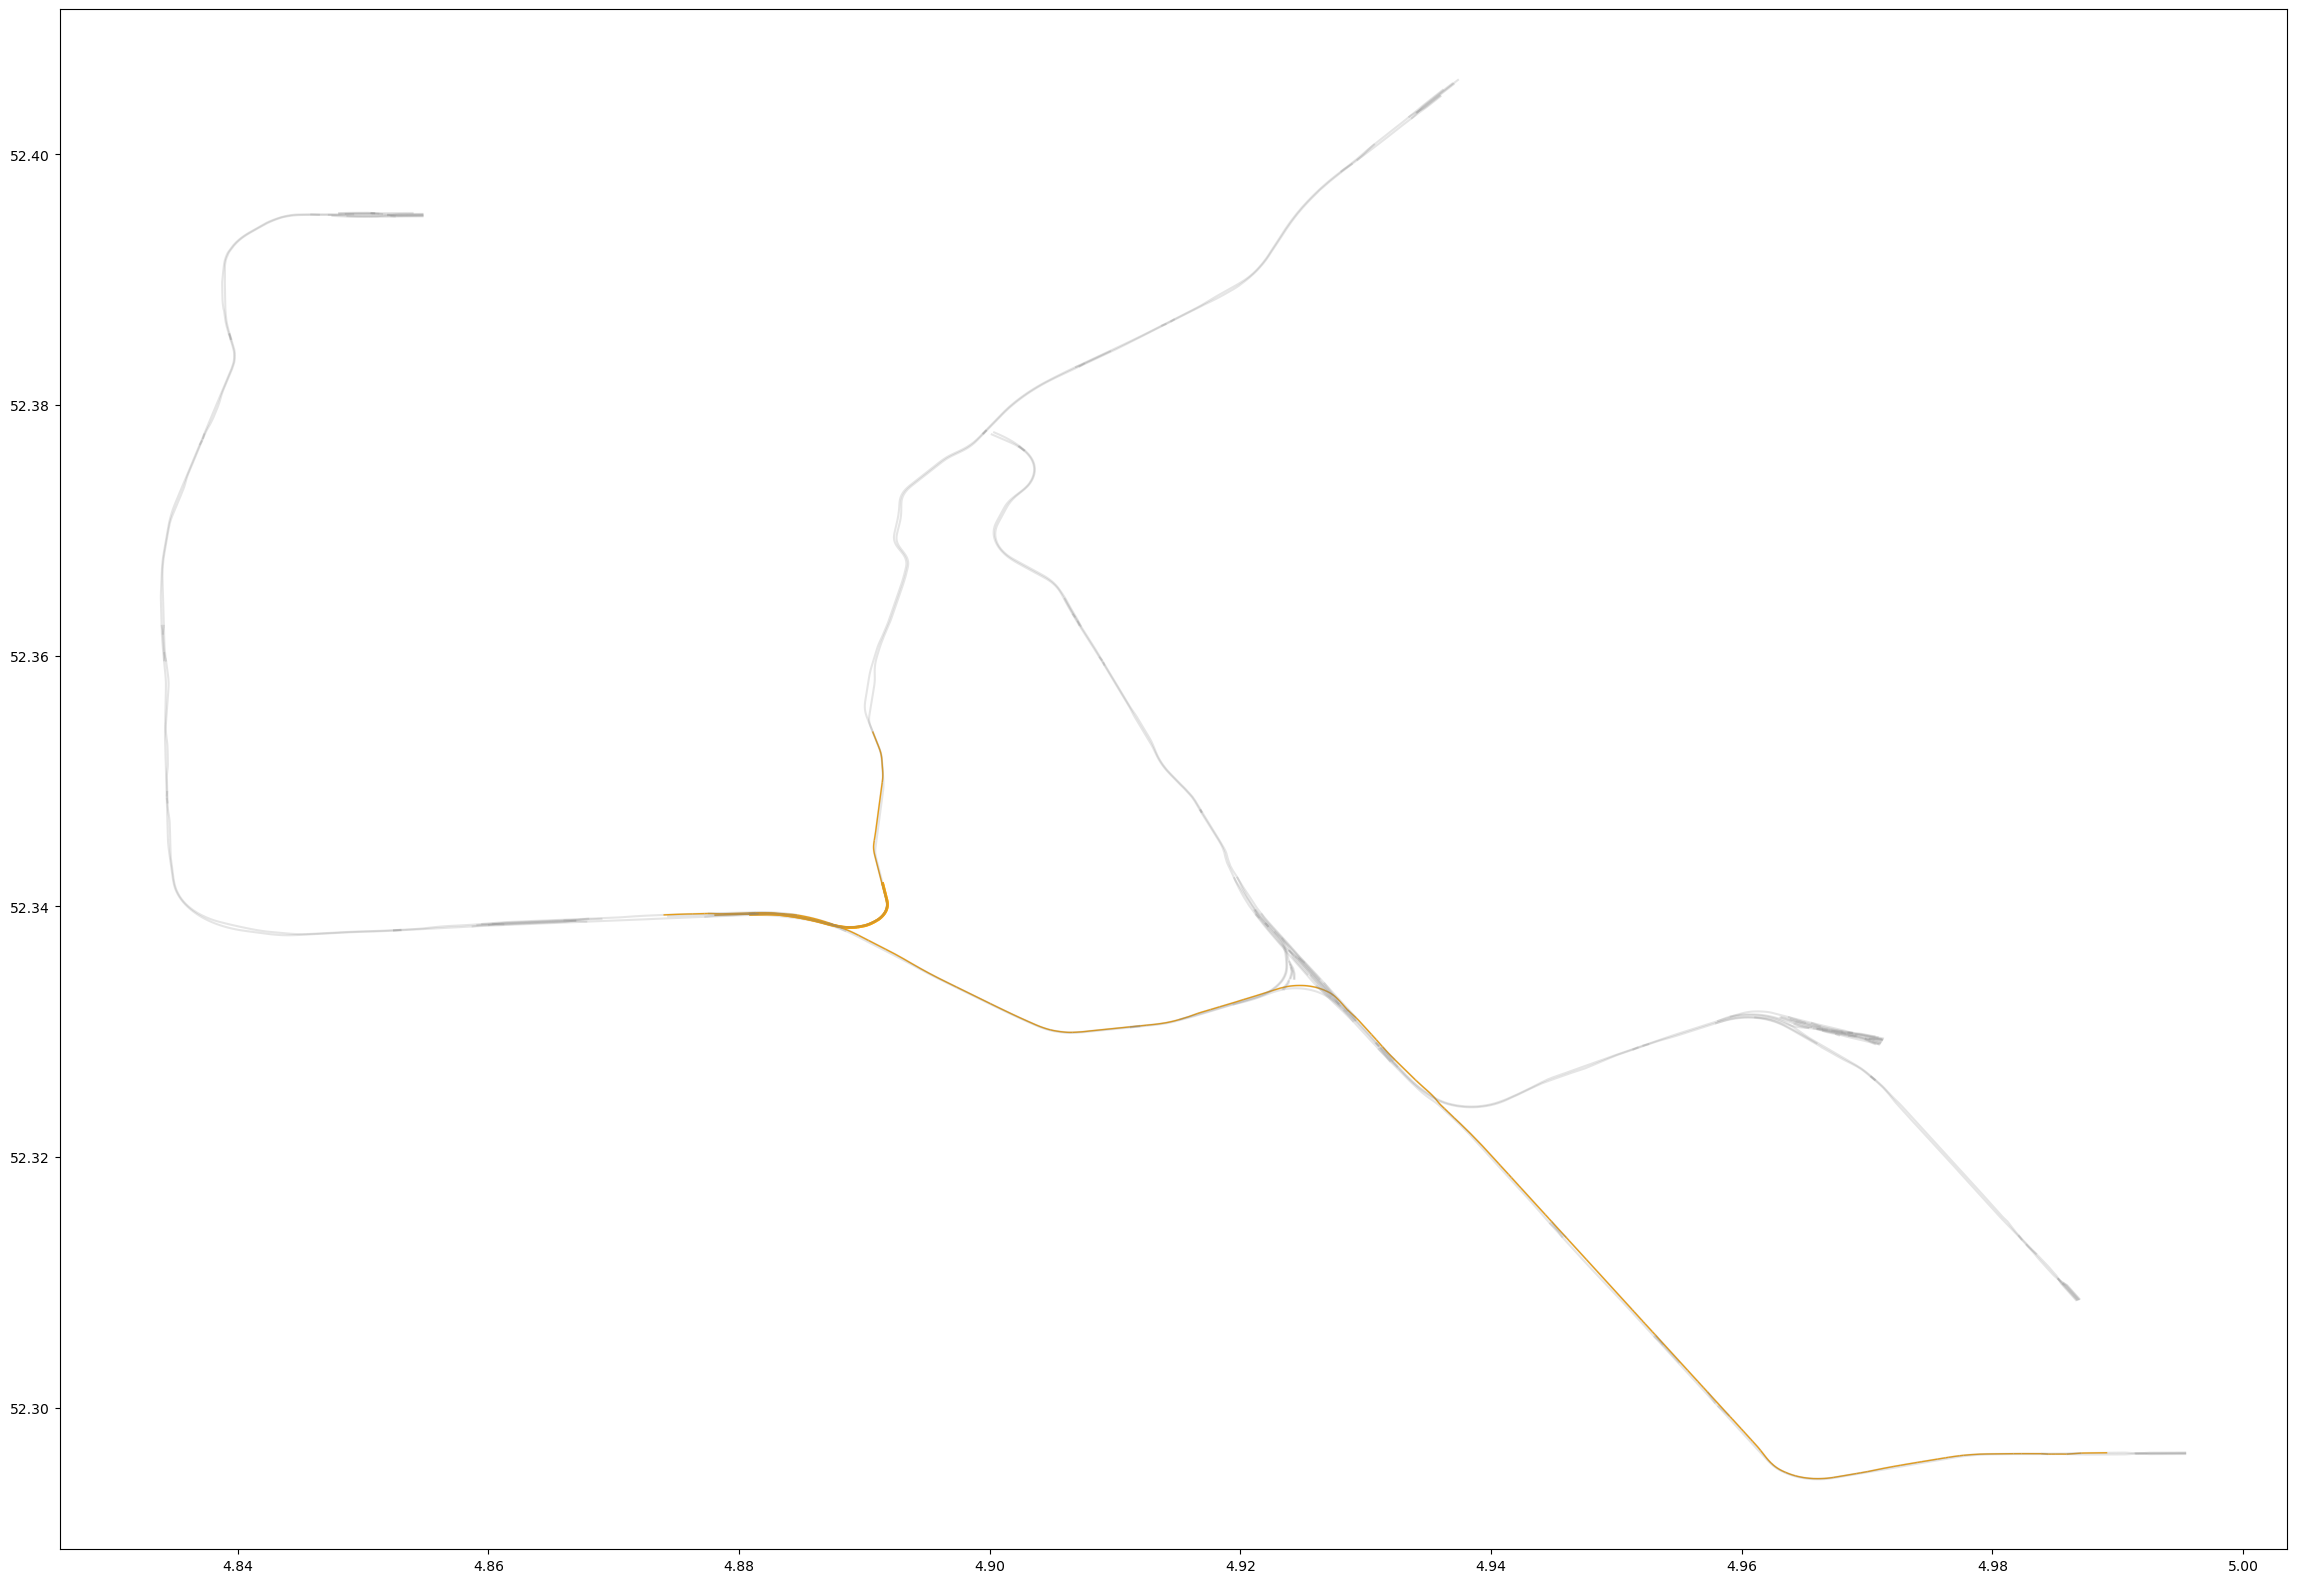

In [59]:
btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])


fig, ax = plt.subplots(1, 1, figsize=(30, 20))
gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')

In [122]:
def all_stations_on_same_route_gdf_transfer(t_e_same_routes_df, city_sub_routes, city_sub_order_route_dict, t_station_node, end_node):
    t_e_on_possible_route_df = pd.merge(t_e_same_routes_df, city_sub_routes, on='ref', how='left')
    t_e_on_route_possible_gdf = gpd.GeoDataFrame(t_e_on_possible_route_df.copy())
    
    all_btw_stations_on_same_route_gdf_t_e = None  
    
    for i in range(len(t_e_on_route_possible_gdf)):
        all_stations_on_possible_route_t_e = city_sub_order_route_dict[t_e_on_route_possible_gdf.name[i]]
    
        all_stations_on_possible_route_t_e_gdf = gpd.GeoDataFrame(all_stations_on_possible_route_t_e.copy())
    
        t_station_node_gdf = gpd.GeoDataFrame(t_station_node.copy())
        end_node_gdf = gpd.GeoDataFrame(end_node.copy())

        t_station_node_index = shapely.distance(t_station_node_gdf.geometry.values, all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
        end_station_index = shapely.distance(end_node_gdf.geometry.values, all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
    
        if t_station_node_index > end_station_index:
            continue  
        else:
            all_btw_stations_on_same_route_gdf_t_e = all_stations_on_possible_route_t_e_gdf.iloc[t_station_node_index:end_station_index+1]
            break
    
    if all_btw_stations_on_same_route_gdf_t_e is None:

        raise ValueError("No suitable stations found.")
    
    return all_btw_stations_on_same_route_gdf_t_e

In [123]:
all_btw_stations_on_same_route_gdf_t_e = all_stations_on_same_route_gdf_transfer(t_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,t_station_node,end_node)
all_btw_stations_on_same_route_gdf_t_e

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value
0,3,Zuid,POINT (4.87802 52.33930),4.878025,52.339303,Metro 52: Zuid => Noord,52,subway,"(4.8780248, 52.3393025)"
1,5,Europaplein,POINT (4.89143 52.34192),4.89143,52.341922,Metro 52: Zuid => Noord,52,subway,"(4.8914299, 52.3419224)"
2,7,De Pijp,POINT (4.89065 52.35396),4.890648,52.353958,Metro 52: Zuid => Noord,52,subway,"(4.8906476, 52.3539585)"
3,6,Vijzelgracht,POINT (4.89122 52.36067),4.891221,52.360666,Metro 52: Zuid => Noord,52,subway,"(4.8912207, 52.3606661)"
4,9,Rokin,POINT (4.89277 52.37044),4.892773,52.370443,Metro 52: Zuid => Noord,52,subway,"(4.8927726, 52.3704434)"
5,0,Centraal Station,POINT (4.90094 52.37919),4.900937,52.379188,Metro 52: Zuid => Noord,52,subway,"(4.9009371, 52.3791884)"
6,2,Noorderpark,POINT (4.91828 52.38859),4.918276,52.388594,Metro 52: Zuid => Noord,52,subway,"(4.9182755, 52.3885941)"


In [124]:
all_btw_stations_on_same_route_gdf_s_t = all_stations_on_same_route_gdf_transfer(s_t_same_routes_df,city_sub_routes,city_sub_order_route_dict,start_node,t_station_node)
all_btw_stations_on_same_route_gdf_s_t

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value,order_index
0,5,Gein,POINT (4.98916 52.29641),4.989161,52.296407,Metro 50: Gein => Isolatorweg,50,subway,"(4.9891612, 52.2964067)",0
1,18,Reigersbos,POINT (4.97400 52.29564),4.974,52.295637,Metro 50: Gein => Isolatorweg,50,subway,"(4.9740002, 52.2956365)",1
2,17,Holendrecht,POINT (4.96013 52.29813),4.960126,52.298132,Metro 50: Gein => Isolatorweg,50,subway,"(4.9601264, 52.2981319)",2
3,6,Bullewijk,POINT (4.95213 52.30687),4.952129,52.306869,Metro 50: Gein => Isolatorweg,50,subway,"(4.9521292, 52.306869)",3
4,4,Bijlmer ArenA,POINT (4.94762 52.31181),4.947618,52.311806,Metro 50: Gein => Isolatorweg,50,subway,"(4.9476178, 52.311806)",4
5,3,Strandvliet,POINT (4.94140 52.31861),4.941398,52.318612,Metro 50: Gein => Isolatorweg,50,subway,"(4.9413977, 52.3186119)",5
6,16,Duivendrecht,POINT (4.93656 52.32360),4.93656,52.323602,Metro 50: Gein => Isolatorweg,50,subway,"(4.9365601, 52.3236024)",6
7,7,Van der Madeweg,POINT (4.93045 52.32978),4.930454,52.329785,Metro 50: Gein => Isolatorweg,50,subway,"(4.9304544, 52.3297847)",7
8,9,Overamstel,POINT (4.91761 52.33177),4.917606,52.331769,Metro 50: Gein => Isolatorweg,50,subway,"(4.9176063, 52.3317688)",8
9,19,Station RAI,POINT (4.88954 52.33769),4.889539,52.337689,Metro 50: Gein => Isolatorweg,50,subway,"(4.889539, 52.337689)",9


In [ ]:
def all_stations_on_same_route_gdf_transfer(t_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,t_station_node,end_node):
    t_e_on_possible_route_df = pd.merge(t_e_same_routes_df, city_sub_routes, on='ref', how='left')
    t_e_on_route_possible_gdf = gpd.GeoDataFrame(t_e_on_possible_route_df.copy())
    
    for i in range(len(t_e_on_route_possible_gdf)):
        all_stations_on_possible_route_t_e = city_sub_order_route_dict[t_e_on_route_possible_gdf.name[i]]
    
        all_stations_on_possible_route_t_e_gdf = gpd.GeoDataFrame(all_stations_on_possible_route_t_e.copy())
    
        t_station_node_gdf = gpd.GeoDataFrame(t_station_node.copy())
        end_node_gdf = gpd.GeoDataFrame(end_node.copy())

        t_station_node_index = shapely.distance(t_station_node_gdf.geometry.values,all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
        end_station_index = shapely.distance(end_node_gdf.geometry.values,all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
    
        if t_station_node_index>end_station_index:
            i = i+1
        else:
            all_btw_stations_on_same_route_gdf_t_e = all_stations_on_possible_route_t_e_gdf.iloc[t_station_node_index:end_station_index+1]
            break
    return all_btw_stations_on_same_route_gdf_t_e

In [58]:
t_e_on_possible_route_df = pd.merge(t_e_same_routes_df, city_sub_routes, on='ref', how='left')
t_e_on_route_possible_gdf = gpd.GeoDataFrame(t_e_on_possible_route_df.copy())
t_e_on_route_possible_gdf

,ref,osm_id,route,to,name,network,service,geometry
0,52,8466667,subway,Zuid,Metro 52: Noord => Zuid,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.93265 52.40228, 4.93269 52..."
1,52,8466671,subway,Noord,Metro 52: Zuid => Noord,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87423 52.33922, 4.87552 52..."


In [102]:
for i in range(len(t_e_on_route_possible_gdf)):
    all_stations_on_possible_route_t_e = city_sub_order_route_dict[t_e_on_route_possible_gdf.name[i]]
    
    all_stations_on_possible_route_t_e_gdf = gpd.GeoDataFrame(all_stations_on_possible_route_t_e.copy())
    
    t_station_node_gdf = gpd.GeoDataFrame(t_station_node.copy())
    end_node_gdf = gpd.GeoDataFrame(end_node.copy())

    t_station_node_index = shapely.distance(t_station_node_gdf.geometry.values,all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
    end_station_index = shapely.distance(end_node_gdf.geometry.values,all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
    
    if t_station_node_index>end_station_index:
        i = i+1
    else:
        all_btw_stations_on_same_route_gdf_t_e = all_stations_on_possible_route_t_e_gdf.iloc[t_station_node_index:end_station_index+1]
        break

In [103]:
all_btw_stations_on_same_route_gdf_t_e

,id,name,geometry,geo_x,geo_y,route_name_list,ref,route,coordinate_value
0,3,Zuid,POINT (4.87802 52.33930),4.878025,52.339303,Metro 52: Zuid => Noord,52,subway,"(4.8780248, 52.3393025)"
1,5,Europaplein,POINT (4.89143 52.34192),4.89143,52.341922,Metro 52: Zuid => Noord,52,subway,"(4.8914299, 52.3419224)"
2,7,De Pijp,POINT (4.89065 52.35396),4.890648,52.353958,Metro 52: Zuid => Noord,52,subway,"(4.8906476, 52.3539585)"
3,6,Vijzelgracht,POINT (4.89122 52.36067),4.891221,52.360666,Metro 52: Zuid => Noord,52,subway,"(4.8912207, 52.3606661)"
4,9,Rokin,POINT (4.89277 52.37044),4.892773,52.370443,Metro 52: Zuid => Noord,52,subway,"(4.8927726, 52.3704434)"
5,0,Centraal Station,POINT (4.90094 52.37919),4.900937,52.379188,Metro 52: Zuid => Noord,52,subway,"(4.9009371, 52.3791884)"
6,2,Noorderpark,POINT (4.91828 52.38859),4.918276,52.388594,Metro 52: Zuid => Noord,52,subway,"(4.9182755, 52.3885941)"


In [101]:
btw_all_id_pairs_list_s_t = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_t_e,city_sub_new_nodes)
btw_all_id_pairs_list_s_t

[  s_id e_id
 0  345  859
 1  859  863
 2  863  862
 3  862  865
 4  865  815
 5  815  817]

In [ ]:
all_stations_on_matched_routes_dfs_t_e = all_stations_on_matched_routes(t_e_same_routes_df,city_sub_routes,t_station_node,end_node,city_sub_order_route_dict)
all_stations_on_matched_routes_dfs_t_e

In [ ]:
btw_stations_each_way_list_t_e = btw_stations_each_way_list(t_station_node,end_node,all_stations_on_matched_routes_dfs_t_e)

In [ ]:
btw_stations_each_way_list_t_e

In [ ]:
btw_all_id_pairs_list_t_e = btw_all_ids_pairs(btw_stations_each_way_list_t_e,city_sub_new_nodes)

In [ ]:
btw_all_id_pairs_list_t_e

In [ ]:
btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])


fig, ax = plt.subplots(1, 1, figsize=(30, 20))
gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')

### Find transfer stations----transfer_station_one_mode

In [ ]:
t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)

In [ ]:
t_station_node

#### Get same_route and all stations between s_t and t_e 

In [ ]:
s_on_route_ref,t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)

In [ ]:
s_t_same_routes_df = s_e_same_routes(s_on_route_ref,t_on_route_ref)
s_t_same_routes_df

In [ ]:
s_t_same_routes_gdf = s_e_same_route_gdf_metro(s_t_same_routes_df,city_sub_routes,start_node)

In [ ]:
s_t_same_routes_gdf

In [ ]:
all_btw_stations_on_same_route_gdf_metro_s_t = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict,s_t_same_routes_gdf,start_node,t_station_node)
all_btw_stations_on_same_route_gdf_metro_s_t

In [ ]:
t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)

In [ ]:
t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
t_e_same_routes_df

In [ ]:
t_e_on_possible_route_df = pd.merge(t_e_same_routes_df, city_sub_routes, on='ref', how='left')
t_e_on_route_possible_gdf = gpd.GeoDataFrame(t_e_on_possible_route_df.copy())
t_e_on_possible_route_df

In [ ]:
end_node_gdf = gpd.GeoDataFrame(end_node.copy())
t_e_on_same_route_gdf = t_e_on_route_possible_gdf[t_e_on_route_possible_gdf.geometry.buffer(0.000001).intersects(end_node_gdf.iloc[0]['geometry'])]
t_e_on_same_route_gdf = t_e_on_same_route_gdf.reset_index(drop = True)
t_e_on_same_route_gdf

In [ ]:
t_e_same_routes_gdf = s_e_same_route_gdf_metro(t_e_same_routes_df,city_sub_routes,end_node)
t_e_same_routes_gdf

In [ ]:
all_stations_on_same_route = city_sub_order_route_dict[t_e_on_route_possible_gdf.name[0]]

all_stations_on_same_route_gdf = gpd.GeoDataFrame(all_stations_on_same_route.copy())

start_node_gdf = gpd.GeoDataFrame(start_node.copy())
end_node_gdf = gpd.GeoDataFrame(end_node.copy())
all_stations_on_same_route_gdf

In [ ]:

start_station_index = shapely.distance(start_node_gdf.geometry.values,all_stations_on_same_route_gdf.geometry.values).argmin()
end_station_index = shapely.distance(end_node_gdf.geometry.values,all_stations_on_same_route_gdf.geometry.values).argmin()
start_station_index

In [ ]:
end_station_index

In [ ]:
all_btw_stations_on_same_route_gdf = all_stations_on_same_route_gdf.iloc[start_station_index:end_station_index+1]

In [ ]:
all_btw_stations_on_same_route_gdf

In [ ]:
all_btw_stations_on_same_route_gdf_metro_t_e = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict,t_e_same_routes_gdf,t_station_node,end_node)
all_btw_stations_on_same_route_gdf_metro_t_e

#### Get all id pairs of s_t and t_e staions

In [ ]:
btw_stations_each_way_list_s_t = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_metro_s_t,city_sub_new_nodes)
btw_stations_each_way_list_s_t

In [ ]:
btw_stations_each_way_list_t_e = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_metro_t_e,city_sub_new_nodes)
btw_stations_each_way_list_t_e

#### Calculate shortest path and plot

In [ ]:
btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_stations_each_way_list_s_t)

In [ ]:
btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_stations_each_way_list_t_e)

In [ ]:
G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)

In [ ]:
shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)

In [ ]:
shortest_path_pairs_way_s_t

In [ ]:
duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)

In [ ]:
shortest_path_edges_way_s_t

In [ ]:
shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)

In [ ]:
shortest_path_pairs_way_t_e

In [ ]:
duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)

In [ ]:
shortest_path_edges_way_t_e

In [ ]:
shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])
shortest_path_edges_way

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)

gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')

In [ ]:
gpd.GeoDataFrame(shortest_path_edges_way[['osm_id', 'geometry','id']]).to_file('shortest_path_edges_way_transfer.GPKG',driver='GPKG')

# Test all OD pairs1

In [ ]:
def test_OD_metro(OD_df,city_sub_new_nodes,city_sub_new_edges,city_sub_routes,city_sub_order_route_dict):
    
    for index, row in OD_df.iterrows():
        OD_pair = pd.Series(row)
        start_node, end_node = s_e_node_df(OD_pair, city_sub_new_nodes)
       
        s_on_route_ref,e_on_route_ref = s_e_on_route_ref(start_node, end_node)
        s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)
        s_e_same_routes_df = s_e_same_routes(s_on_route_ref,e_on_route_ref)
        if s_e_same_routes_df is None:
            t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)
            if  t_station_node.iloc[0][3] == start_node.iloc[0][3]:
                t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
                t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
                all_stations_on_matched_routes_dfs_t_e = all_stations_on_matched_routes(t_e_same_routes_df,city_sub_routes,t_station_node,end_node,city_sub_order_route_dict)
                btw_stations_each_way_list_t_e = btw_stations_each_way_list(t_station_node,end_node,all_stations_on_matched_routes_dfs_t_e)
                
                btw_all_id_pairs_list_t_e = btw_all_ids_pairs(btw_stations_each_way_list_t_e,city_sub_new_nodes)
                btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)
                G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
                shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
                duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)

                fig, ax = plt.subplots(1, 1, figsize=(30, 20))
                gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
                gpd.GeoDataFrame(shortest_path_edges_way_t_e.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way_t_e.count_weight), color='orange')
                print(index)
                
            else:
                s_on_route_ref,t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)
                s_t_same_routes_df = s_e_same_routes(s_on_route_ref,t_on_route_ref)
                all_stations_on_matched_routes_dfs_s_t = all_stations_on_matched_routes(s_t_same_routes_df,city_sub_routes,start_node,t_station_node,city_sub_order_route_dict)
                btw_stations_each_way_list_s_t = btw_stations_each_way_list(start_node,t_station_node,all_stations_on_matched_routes_dfs_s_t)
            
                t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
                t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
                all_stations_on_matched_routes_dfs_t_e = all_stations_on_matched_routes(t_e_same_routes_df,city_sub_routes,t_station_node,end_node,city_sub_order_route_dict)
                btw_stations_each_way_list_t_e = btw_stations_each_way_list(t_station_node,end_node,all_stations_on_matched_routes_dfs_t_e)
            
                btw_all_id_pairs_list_s_t = btw_all_ids_pairs(btw_stations_each_way_list_s_t,city_sub_new_nodes)
                btw_all_id_pairs_list_t_e = btw_all_ids_pairs(btw_stations_each_way_list_t_e,city_sub_new_nodes)
            
                btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
                btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

                G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
                shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
                duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
                shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
                duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
                shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])
            

                fig, ax = plt.subplots(1, 1, figsize=(30, 20))
                gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
                gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')
                print(index)
                
        else:
            s_e_on_same_route_gdf = s_e_same_route_gdf_metro(s_e_same_routes_df,city_sub_routes,start_node)
        
            all_btw_stations_on_same_route_gdf = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict, s_e_on_same_route_gdf, start_node, end_node)
            btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf,city_sub_new_nodes)
            btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)
            G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
            shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)
            duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_new_nodes)
            fig, ax = plt.subplots(1, 1, figsize=(30, 20))
            gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
            gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')
            print(index)

In [ ]:
test_OD_metro(OD_df,city_sub_new_nodes,city_sub_new_edges,city_sub_routes,city_sub_order_route_dict)

# Connet 52 to other three routes

In [ ]:
from shapely.geometry import Point, Polygon, LineString

In [ ]:
central_stations_gdf = gpd.GeoDataFrame(city_sub_stations[city_sub_stations.name == 'Centraal Station'].copy())
central_stations_gdf = central_stations_gdf.reset_index(drop=True)
central_stations_gdf

In [ ]:
nodes[nodes.geometry == central_stations_gdf.loc[0, 'geometry']]

In [ ]:
nodes[nodes.geometry == central_stations_gdf.loc[1, 'geometry']]

In [ ]:
nodes[nodes.geometry == central_stations_gdf.loc[2, 'geometry']]

In [ ]:
nodes[nodes.geometry == central_stations_gdf.loc[3, 'geometry']]

In [ ]:
# 选择两个点
point_a = central_stations_gdf.loc[1, 'geometry']
point_b = central_stations_gdf.loc[3, 'geometry']

# 创建连接这两个点的线
line = LineString([point_a, point_b])

# 创建一个包含线的DataFrame
edges_central1 = gpd.GeoDataFrame({'id': [1], 'geometry': [line]}, geometry='geometry')

In [ ]:
edges_central1

In [ ]:
# 选择两个点
point_a = central_stations_gdf.loc[0, 'geometry']
point_b = central_stations_gdf.loc[2, 'geometry']

# 创建连接这两个点的线
line = LineString([point_a, point_b])

# 创建一个包含线的DataFrame
edges_central2 = gpd.GeoDataFrame({'id': [1], 'geometry': [line]}, geometry='geometry')
edges_central2

In [ ]:
city_sub_new_edges_central = pd.concat([city_sub_new_edges,edges_central1])
city_sub_new_edges_central

In [ ]:
city_sub_new_edges